<a href="https://colab.research.google.com/github/kirinikini21/Deep-Learning/blob/main/231204_Image_Colorization_with_U_Net_and_GAN_%EC%86%A1%ED%95%B4%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization with U-Net and GAN Tutorial

In [ ]:
# #Google Colab 환경에서 구글 드라이브를 마운트
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


**If you have already read the explanations, you can directly go to the code starting with heading: _1 - Implementing the paper - Our Baseline_**

![title image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/main.png?raw=1)

딥러닝의 가장 흥미로운 응용 중 하나는 흑백 이미지에 색상을 입히는 작업입니다. 몇 년 전에는 이 작업에는 많은 인간의 노력과 하드코딩이 필요했지만, 이제는 인공 지능과 딥러닝의 능력을 통해 전체 프로세스를 end-to-end로 수행할 수 있습니다. 아마도 이 작업을 위해 모델을 처음부터 훈련시키기 위해 엄청난 양의 데이터나 긴 훈련 시간이 필요할 것으로 생각할 수 있지만, 지난 몇 주 동안 여러 다양한 모델 아키텍처, 손실 함수, 훈련 전략 등을 실험하면서 실제로는 상당히 작은 데이터셋 및 짧은 훈련 시간으로도 모델을 효과적으로 훈련시킬 수 있는 전략을 개발했습니다. 이 글에서는 이를 가능케 하기 위해 수행한 작업과 코드, 도움이 되었던 전략 및 쓸모 없었던 것들에 대해 설명하겠습니다. 그 전에 색상화 문제를 설명하고 최근 몇 년 동안 어떤 일이 벌어졌는지 간단히 검토하겠습니다. 이 글의 나머지 부분에 대해 기본적인 딥러닝, GAN 및 PyTorch 라이브러리에 대한 지식이 있다고 가정하겠습니다. 시작해 봅시다!

## Introduction to colorization problem

여기서는 이후 코드에서 모델이 수행하는 작업을 이해하는 데 필요한 몇 가지 기본 지식을 제공하겠습니다.

### RGB vs L\*a\*b

RGB 이미지를 로드하면 높이, 너비, 색상이라는 세 축을 가진 순위 3(높이, 너비, 색상) 배열이 생성됩니다. 이 배열의 마지막 축에는 이미지의 색상 데이터가 포함되어 있습니다. 이 데이터는 RGB 색상 공간에서 색상을 나타내며 각 픽셀마다 픽셀이 얼마나 빨간색, 녹색 및 파란색인지를 나타내는 3개의 숫자가 있습니다. 아래 이미지에서 볼 수 있듯이 "main image"의 왼쪽 부분에서는 파란색이 있으므로 이미지의 파란색 채널에서 해당 부분에 더 높은 값이 있어 어둡게 표시됩니다.

![rgb image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/rgb.jpg?raw=1)

L\*a\*b 색상 공간에서도 각 픽셀에 대해 세 개의 숫자가 있지만 이 숫자에는 다른 의미가 있습니다. 첫 번째 숫자(채널), L은 각 픽셀의 밝기를 인코딩하며 이 채널을 시각화하면(아래 행의 두 번째 이미지), 흑백 이미지로 나타납니다. \*a 및 \*b 채널은 각각 픽셀이 녹색-빨간색 및 노랑-파랑인지를 나타냅니다. 다음 이미지에서 L\*a\*b 색상 공간의 각 채널을 별도로 볼 수 있습니다.

![lab image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/lab.jpg?raw=1)

내가 연구한 논문들과 GitHub에서 확인한 컬러화 관련 코드들에서 모두 L\*a\*b 색상 공간을 사용하는 것을 알 수 있었습니다. 이 선택에는 몇 가지 이유가 있지만, 여기서는 이 선택의 직관적인 이유에 대해 설명하겠습니다. 컬러화를 위해 모델을 훈련시키기 위해서는 그레이스케일 이미지를 입력으로 제공하고 모델이 해당 이미지를 다채로운 컬러로 만들 것으로 기대합니다. L\*a\*b를 사용하면 모델에 L 채널을 제공할 수 있으며(이는 그레이스케일 이미지입니다), 나머지 두 채널(\*a, \*b)을 예측하도록 기대할 수 있습니다. 그리고 예측 이후에는 모든 채널을 연결하여 다채로운 이미지를 얻을 수 있습니다. 그러나 RGB를 사용하는 경우 이미지를 먼저 그레이스케일로 변환하고 이를 모델에 공급하고 모델이 세 개의 숫자를 예측하도록 기대해야 합니다. 이는 세 개의 숫자에 대한 많은 가능한 조합으로 인해 훨씬 어려우며 불안정한 작업입니다. 각 숫자에 대해 256가지 선택지가 있다고 가정하면(8비트 무부호 정수 이미지의 경우 실제 선택지 수입니다), 각 픽셀에 대해 세 숫자를 예측하는 것은 256³ 조합 중에서 선택해야 하는데, 이는 1600만 개 이상의 선택지가 됩니다. 그러나 두 숫자를 예측하는 경우 약 65000가지 선택지가 있습니다(실제로 이 작업을 분류 작업처럼 무작위로 선택하지는 않으며, 이 숫자는 직관을 주기 위해 작성된 것입니다).

## How to solve the problem

지난 몇 년 동안 딥러닝을 사용하여 이미지를 컬러화하기 위한 여러 가지 다른 솔루션이 제안되었습니다. Colorful Image Colorization 논문은 문제를 분류 작업으로 접근했으며 이 문제의 불확실성을 고려했습니다(예: 이미지의 차는 여러 가지 다양하고 유효한 색상을 가질 수 있으며 이에 대해 확실한 색상을 알 수 없습니다). 다른 논문은 문제를 회귀 작업으로 접근했습니다(일부 조정 포함!). 각 접근 방식에는 장단점이 있지만, 이 글에서는 다른 전략을 사용할 것입니다.

### The strategy we are going to use

[_**Image-to-Image Translation with Conditional Adversarial Networks**_](https://arxiv.org/abs/1611.07004) 논문, 일명 pix2pix라고 알려져 있는 논문은 컬러화를 포함한 여러 이미지 대 이미지 작업에 대한 일반적인 해결책을 제안했습니다. 이 방법에서는 두 가지 손실이 사용됩니다. 첫째로 L1 손실은 이것을 회귀 작업으로 만듭니다. 둘째로 적대적 손실(GAN 손실)은 문제를 비지도 학습 방식으로 해결하는 데 도움이 됩니다(출력에 "얼마나 실제 같아 보이는지"를 나타내는 숫자를 할당함으로써!).

이 튜토리얼에서는 먼저 논문의 저자들이 한 것을 구현한 다음, 완전히 새로운 생성자 모델과 훈련 전략의 몇 가지 수정을 소개할 것입니다. 이 수정은 놀라운 결과를 얻으면서 필요한 데이터셋 크기를 크게 줄이는 데 큰 도움이 됩니다. 계속 주목해 주세요 :)

### A deeper dive into GAN world

이전에 언급한 대로, 우리는 GAN(구체적으로 조건부 GAN)을 구축하고 추가 손실 함수인 L1 손실을 사용할 것입니다. 먼저 GAN부터 시작해 봅시다.

GAN에서는 생성자와 판별자 모델이 함께 문제를 해결하는 방식으로 학습됩니다. 우리의 설정에서 생성자 모델은 그레이스케일 이미지(1채널 이미지)를 가져와 \*a와 \*b를 위한 두 채널의 이미지를 생성합니다. 판별자는 이 두 생성된 채널을 가져와 입력 그레이스케일 이미지와 연결한 다음, 이 새로운 3채널 이미지가 가짜인지 실제인지를 결정합니다. 물론 판별자는 또한 생성자에 의해 생성되지 않은 실제 이미지(다시 한번 Lab 색상 공간의 3채널 이미지)를 보아야 하며 이것이 실제임을 학습해야 합니다.

그렇다면 우리가 언급한 "조건"은 어떨까요? 실제로 생성자와 판별자가 모두 본 그레이스케일 이미지는 GAN에서 두 모델에게 제공하는 조건입니다. 이 조건을 모델이 고려하도록 기대하고 있습니다.

수학적으로 살펴보겠습니다. 그레이스케일 이미지를 _**x**_, 생성자에 대한 입력 노이즈를 _**z**_, 생성자에서 얻고자 하는 2채널 출력을 _**y**_로 간주해 보겠습니다(실제 이미지의 2색 채널을 나타낼 수도 있습니다). 또한 _**G**_가 생성자 모델이고 _**D**_가 판별자입니다. 그렇다면 조건부 GAN의 손실은 다음과 같습니다:

![GAN Loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/GAN_loss.jpg?raw=1)

_**x**_가 두 모델에게 주어지는 것에 주목하세요. 이는 이 게임의 양 플레이어에게 도입하는 조건입니다. 실제로 우리는 무작위 노이즈의 "n" 차원 벡터를 생성자에 공급하는 것이 아니라 노이즈가 생성자 아키텍처 내의 드롭아웃 레이어의 형태로 도입됩니다(이에 관한 멋진 내용이 있으며 이는 글의 마지막 부분에서 읽을 수 있습니다).

### Loss function we optimize

앞서 손실 함수는 현실적인 것처럼 보이는 다채로운 이미지를 생성하는 데 도움이 되지만 모델을 더 지원하고 작업에 약간의 지도를 소개하기 위해 이 손실 함수와 예측된 색상과 실제 색상 간의 L1 손실(평균 절대 오차로도 알려진)을 결합합니다.

![L1 loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/l1_loss.jpg?raw=1)

만약 L1 손실만 사용한다면 모델은 이미지에 색상을 입히기는 하지만 주로 "회색"이나 "갈색"과 같은 색상을 사용하게 될 것입니다. 의심스러운 경우 어떤 색상이 가장 좋은지 알 수 없을 때, 모델은 평균을 취하고 L1 손실을 최소화하기 위해 이러한 색상을 사용하여 결과적으로 이미지에 블러 효과가 나타납니다(L1 또는 L2 손실이 초고해상도 작업에서 블러 효과를 유발하는 것과 유사함). 또한 L1 손실이 L2 손실(또는 평균 제곱 오차)보다 우선되는 이유는 회색 같은 이미지를 생성하는 효과를 줄이기 때문입니다. 따라서 결합된 손실 함수는 다음과 같습니다:

![loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/loss.jpg?raw=1)

여기서 _**λ**_는 두 손실이 최종 손실에 기여하는 정도를 균형있게 맞추기 위한 계수입니다(물론 판별자 손실에는 L1 손실이 포함되지 않습니다).

알겠습니다. 이론적인 부분은 충분하다고 생각하시나요! 이제 코드로 넘어가 봅시다. 다음 섹션에서는 먼저 논문을 구현하는 코드를 소개하고 그 다음 섹션에서는 1~2시간의 훈련으로 정말 놀라운 결과를 얻을 수 있는 훨씬 효과적인 전략을 소개할 것입니다!

## 1 - Implementing the paper - Our Baseline

### 1.1- Loading Image Paths

이 논문에서는 전체 ImageNet 데이터셋(약 130만 장의 이미지!)을 사용했지만, 여기서는 내 디바이스에 사용 가능한 COCO 데이터셋의 이미지 8,000장만 사용합니다. 따라서 우리의 훈련 세트 크기는 논문에서 사용된 데이터셋의 0.6%에 불과합니다!
이 작업에는 원하는대로 다양한 장면과 위치를 포함한 거의 모든 데이터셋을 사용할 수 있습니다. ImageNet을 예로 들 수 있지만 이 프로젝트에는 그 중 8,000장만 필요할 것입니다.

In [ ]:
import os  # 파일 및 디렉토리 조작을 위한 모듈
import glob  # 파일 목록을 얻기 위한 모듈
import time  # 시간 관련 모듈
import numpy as np  # 수학 및 배열 처리를 위한 모듈
from PIL import Image  # 이미지 처리를 위한 모듈
from pathlib import Path  # 파일 경로 다루기를 위한 모듈
from tqdm.notebook import tqdm  # 진행 상황을 시각화하기 위한 모듈
import matplotlib.pyplot as plt  # 그래픽 출력을 위한 모듈
from skimage.color import rgb2lab, lab2rgb  # 이미지 컬러 공간 변환을 위한 모듈

import torch  # PyTorch 라이브러리
from torch import nn, optim  # 신경망 및 최적화 관련 모듈
from torchvision import transforms  # 이미지 변환을 위한 모듈
from torchvision.utils import make_grid  # 그리드 형태로 이미지를 결합하는 함수
from torch.utils.data import Dataset, DataLoader  # 데이터 로딩을 위한 모듈

# CUDA가 사용 가능하면 GPU로, 그렇지 않으면 CPU로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Google Colab 환경에서 실행 중인지 여부를 확인하기 위한 변수
use_colab = None


### 1.1.x Preparing Colab for running the code

Google Colab에서 이 문서를 열고 있다면 fastai를 설치하도록 다음 코드 주석을 해제하고 실행할 수 있습니다. 튜토리얼의 대부분 코드는 순수 PyTorch로 작성되어 있습니다. 여기서는 fastai가 필요한 이유는 COCO 데이터셋의 일부를 다운로드하고 튜토리얼의 두 번째 섹션에서 다른 한 단계에서 사용하기 때문입니다.

또한 모델을 훨씬 빠르게 훈련할 수 있도록 런타임을 GPU로 설정해야 합니다.

In [ ]:
# fastai 라이브러리의 버전 2.4를 설치하기 위한 명령어
!pip install fastai==2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 7.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.10,>=1.7.0 (from fastai) (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1)
ERROR: No matching distribution found for torch<1.10,>=1.7.0



다음 코드는 COCO 데이터셋에서 약 20,000장의 이미지를 다운로드합니다. 우리는 훈련에는 이 중 8,000장만 사용할 것이므로 주의하세요. 또한 ImageNet과 같은 다른 데이터셋을 사용할 수도 있습니다. 중요한 것은 다양한 장면과 위치를 포함하고 있어야 합니다.

제가 코드를 직접 실행하거나 설치 명령을 실행할 수는 없지만, 여러분이 따라서 실행할 수 있도록 아래는 fastai를 설치하는 코드입니다. 아래 코드를 Google Colab 환경에서 실행하세요.

In [ ]:
# from fastai.data.external import untar_data, URLs
# coco_path = untar_data(URLs.COCO_SAMPLE)
# coco_path = str(coco_path) + "/train_sample"
# use_colab = True

In [ ]:
# Google Colab에서 Google Drive를 마운트하는 코드

# 필요한 라이브러리를 가져옵니다.
from google.colab import drive

# Google Drive를 Colab에 마운트합니다.
drive.mount('/content/drive')

# 마운트 경로는 일반적으로 '/content/drive'로 설정됩니다.
# Google Drive의 루트 폴더는 '/content/drive/My Drive/'에 연결됩니다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # 필요한 라이브러리를 가져옵니다.
# import glob
# import numpy as np

# # Google Drive에서 이미지 파일들이 저장된 경로를 지정합니다.
# path = "/content/drive/MyDrive/songhae"

# # 지정된 경로에서 모든 JPG 파일들을 찾아 리스트로 반환합니다.
# paths = glob.glob(path + "/*.jpg")

# # 만약 지정된 경로에 JPG 파일이 없다면 ValueError를 발생시킵니다.
# if not paths:
#     raise ValueError("No JPG files found in the specified directory.")

# # 샘플 크기를 결정합니다. 최대 2000개의 파일을 대상으로 합니다.
# # paths 리스트의 길이에 따라서 샘플 크기를 조정합니다.
# sample_size = min(2000, len(paths))

# # 난수 발생기를 초기화하여 paths 리스트에서 무작위로 샘플을 선택합니다.
# np.random.seed(123)
# paths_subset = np.random.choice(paths, sample_size, replace=False)

# # 코드 실행 중간에 콘솔에 출력을 추가하여 현재 상태를 확인합니다.
# print("Number of items in paths:", len(paths))

# Google Colab 환경에서 코드가 실행 중인지 확인
if use_colab == True:
    path ="/content/drive/MyDrive/songhae"
else:
    path = "/content/drive/MyDrive/songhae"

# glob을 사용하여 지정된 디렉토리의 모든 JPEG 이미지 파일 경로 목록 가져오기
paths = glob.glob(path + "/*.jpeg")
# 재현성을 위해 난수 시드 설정
np.random.seed(123)
# 중복 없이 2000개의 경로를 무작위로 선택
paths_subset = np.random.choice(paths, 2000, replace=False)
# 0에서 1999까지의 인덱스를 무작위로 섞음
rand_idxs = np.random.permutation(2000)

train_idxs = rand_idxs[:1500]  # 처음 1500개의 인덱스를 훈련 세트로 선택
val_idxs = rand_idxs[1500:]    # 나머지 500개의 인덱스를 검증 세트로 선택
train_paths = paths_subset[train_idxs]      # 훈련 및 검증 세트에 해당하는 파일 경로를 선택
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))     # 훈련 세트와 검증 세트의 이미지 수 출력

1500 500


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


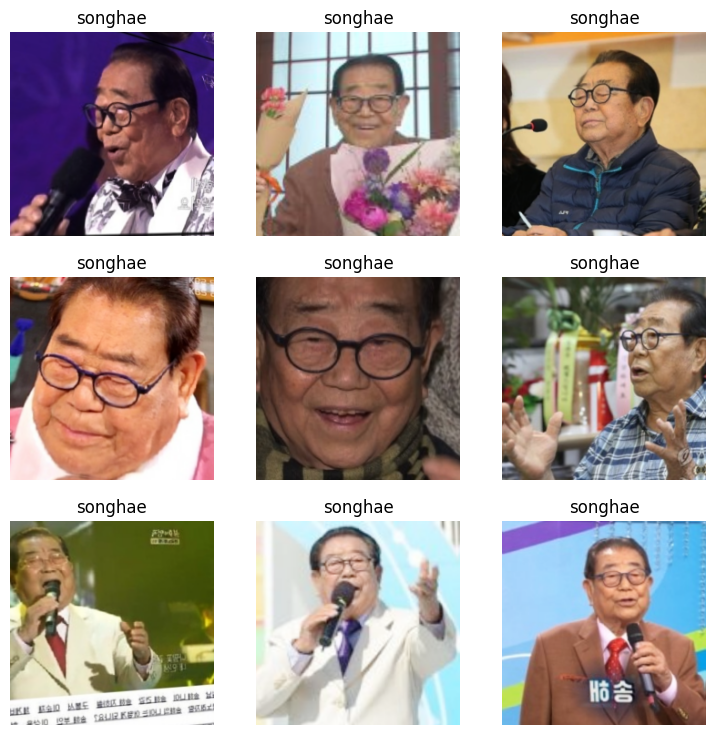

In [ ]:
# fastai 라이브러리의 vision 모듈에서 모든 것을 가져옵니다.
from fastai.vision.all import *

# 로컬 이미지 폴더의 경로를 지정합니다.
custom_dataset_path = Path('/content/drive/MyDrive/songhae')

# 이미지 파일을 가져오는 함수를 정의합니다.
def get_image_files_custom_path(path):
    return get_image_files(path)

# DataBlock을 생성합니다.
# - blocks: ImageBlock(이미지), CategoryBlock(카테고리)을 사용합니다.
# - get_items: 이미지 파일을 가져오는 함수를 지정합니다.
# - splitter: 데이터를 트레이닝셋과 밸리데이션셋으로 나누는 비율을 설정합니다.
# - get_y: 카테고리를 가져오는 함수를 지정합니다.
# - item_tfms: 이미지 크기를 조정하는 등의 아이템 전처리를 수행하는 함수를 지정합니다.
# - batch_tfms: 배치 전체에 적용되는 전처리를 수행하는 함수를 지정합니다.
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files_custom_path,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=parent_label,
                   item_tfms=Resize(460, 460),  #(460) 추가
                   batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

# 전체 데이터 수를 8000개로 변경합니다.
# 트레이닝셋과 밸리데이션셋을 8:2로 나눕니다.
dls = dblock.dataloaders(custom_dataset_path, num_workers=0)

# 생성된 데이터로더를 사용하여 이미지 배치를 시각화합니다.
dls.show_batch()


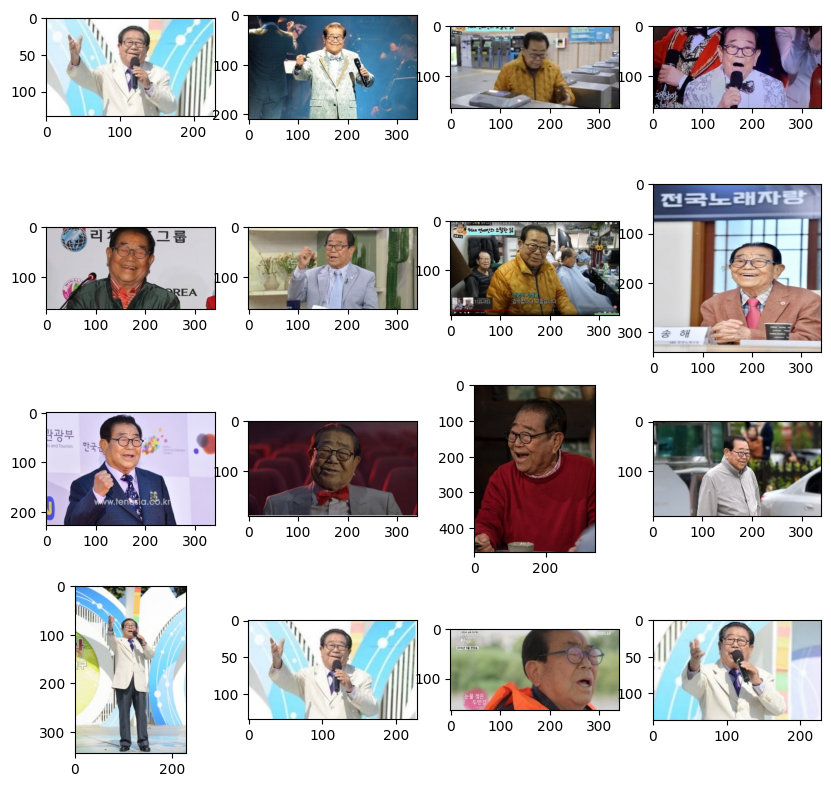

In [ ]:
# Subplots를 생성하여 4x4의 그리드를 만듭니다. 각 subplot의 크기는 10x10입니다. / 5x5
_, axes = plt.subplots(4, 4, figsize=(10, 10))

# train_paths에 있는 이미지 경로를 하나씩 가져와서 subplot에 시각화합니다.
# axes.flatten()을 사용하여 4x4 그리드의 각 subplot에 대한 iterator를 얻습니다.
for ax, img_path in zip(axes.flatten(), dls.train_ds.items):
    # 이미지를 열어서 subplot에 표시합니다.
    img = PILImage.create(img_path)
    img.show(ax=ax)

    # subplot의 축을 제거(off)합니다. / 추가
    ax.axis("on")


우리는 동일한 데이터셋과 훈련 샘플 수를 사용하고 있지만, 정확한 8000장의 이미지는 다를 수 있습니다 (데이터셋은 시드값을 사용하고 있습니다!). 여기서의 데이터셋은 서로 다른 순서로 20,000장의 이미지만 포함하고 있으며, 나는 완전한 데이터셋에서 10,000장을 샘플링했기 때문입니다.

### 1.2- Making Datasets and DataLoaders

코드가 자명한지 바랍니다. 이미지를 크기 조정하고 수평으로 뒤집은 다음 (훈련 세트인 경우에만 뒤집음), RGB 이미지를 읽어 Lab 색상 공간으로 변환하고 첫 번째 (그레이스케일) 채널과 색상 채널을 각각 모델의 입력 및 타겟으로 분리합니다. 그런 다음 데이터 로더를 만듭니다.

In [ ]:
SIZE = 256

class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        # 데이터셋이 트레이닝셋인 경우와 밸리데이션셋인 경우에 대한 전처리를 설정합니다.
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),  # 이미지 크기 조정 및 보간법 설정
                transforms.RandomHorizontalFlip(),  # 약간의 데이터 증강 (랜덤 수평 뒤집기)
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)  # 이미지 크기 조정만 수행

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        # 이미지 파일을 열어서 RGB로 변환합니다.
        img = Image.open(self.paths[idx]).convert("RGB")

        # 설정된 전처리를 수행합니다.
        img = self.transforms(img)

        # 이미지를 NumPy 배열로 변환합니다.
        img = np.array(img)

        # RGB 이미지를 L*a*b 색 공간으로 변환합니다.
        img_lab = rgb2lab(img).astype("float32")  # Converting RGB to L*a*b

        # PyTorch 텐서로 변환합니다.
        img_lab = transforms.ToTensor()(img_lab)

        # L 채널을 추출하고 값을 -1에서 1로 정규화합니다.
        L = img_lab[[0], ...] / 50. - 1.  # Between -1 and 1

        # a, b 채널을 추출하고 값을 -1에서 1로 정규화합니다.
        ab = img_lab[[1, 2], ...] / 110.  # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    # ColorizationDataset을 기반으로 하는 DataLoader를 생성하는 함수입니다.
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader


In [ ]:
train_paths = glob.glob("/content/drive/MyDrive/songhae/*.jpeg")
val_paths = glob.glob("/content/drive/MyDrive/songhae-test/*.jpeg")


# train_paths를 사용하여 트레이닝 데이터로더를 생성합니다.
train_dl = make_dataloaders(paths=train_paths, split='train')

# val_paths를 사용하여 밸리데이션 데이터로더를 생성합니다.
val_dl = make_dataloaders(paths=val_paths, split='val')

# 다음 반복(iteration)에서의 데이터를 가져와서 확인해봅니다.
data = next(iter(train_dl), None)

# 만약 에폭이 끝나면 None이 반환됩니다.
if data is not None:
    # 데이터로더에서 가져온 데이터의 L 채널과 ab 채널의 shape를 출력합니다.
    Ls, abs_ = data['L'], data['ab']
    print("L channel shape:", Ls.shape)
    print("ab channels shape:", abs_.shape)
else:
    print("End of epoch. Resetting the dataloader for the next epoch.")
    train_dl = make_dataloaders(paths=train_paths, split='train')


L channel shape: torch.Size([16, 1, 256, 256])
ab channels shape: torch.Size([16, 2, 256, 256])


In [ ]:
# make_dataloaders 함수를 사용하여 훈련 및 검증 데이터 로더 생성
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

# 훈련 데이터 로더에서 다음 배치를 가져와서 데이터 확인
data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']

# 훈련 데이터의 L 및 ab 채널의 형태 출력
print(Ls.shape, abs_.shape)
# 훈련 및 검증 데이터 로더의 길이 출력
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
400 32


### 1.3- Generator proposed by the paper

이 부분은 다소 복잡하며 설명이 필요합니다. 이 코드는 GAN의 생성자로 사용될 U-Net을 구현합니다. 코드의 세부 내용은 이 문서의 범위를 벗어나지만 중요한 점은 U-Net을 중간 부분에서 만들고 (U 모양 아래에서) 각 반복에서 중간 모듈의 왼쪽과 오른쪽에 (각각) 다운 샘플링 및 업 샘플링 모듈을 추가한다는 것입니다. 입력 모듈 및 출력 모듈에 도달할 때까지 이 작업을 반복합니다. 다음 이미지를 살펴보세요. 이 이미지는 글에서 가져온 이미지 중 하나를 사용하여 코드에서 무슨 일이 일어나고 있는지 더 잘 이해할 수 있도록 만들었습니다.

![unet](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/unet.png?raw=1)

파란색 사각형은 관련된 모듈이 코드로 어떤 순서로 생성되는지를 나타냅니다. 우리가 구축할 U-Net은 이미지에 표시된 것보다 더 많은 레이어를 가지고 있지만 여러분에게 개념을 전달하는 데 충분합니다. 또한 코드에서 8개의 레이어로 내려가고 있음을 주목하세요. 따라서 256x256 이미지로 시작하면 U-Net의 중간에서 1x1 (256 / 2⁸) 이미지를 얻게 되고 그런 다음 이를 업 샘플링하여 256x256 이미지 (두 개의 채널)를 생성합니다. 이 코드 조각은 정말로 흥미롭고 각 줄이 무엇을 하는지 완전히 이해하기 위해 이것과 놀 것을 강력히 추천합니다.

In [ ]:
#U-Net 아키텍처를 정의하는 PyTorch 모델.
#UnetBlock 클래스는 U-Net의 각 블록을 정의하고, Unet 클래스는 전체 U-Net 아키텍처를 정의


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        # 다운샘플링을 위한 컨볼루션 레이어 및 활성화 함수 정의
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        # 업샘플링을 위한 활성화 함수 및 정규화 레이어 정의
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            # 최외곽 블록인 경우 업샘플링 레이어에 Tanh 활성화 함수 사용
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            # 최내곽 블록인 경우 업샘플링 레이어에 bias를 사용하지 않는 컨볼루션 레이어 사용
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            # 중간 블록인 경우 드롭아웃을 사용할 수 있는 경우 드롭아웃 레이어 추가
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        # 최내곽 블록 생성
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        # 다운샘플링 블록 생성
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        # 업샘플링 블록 생성
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        # 최외곽 블록 생성
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

우리의 판별자의 구조는 꽤 간단합니다. 이 코드는 Conv-BatchNorm-LeakyReLU 블록을 쌓아올려 입력 이미지가 가짜인지 실제인지를 결정하는 모델을 구현합니다. 첫 번째 블록과 마지막 블록은 정규화를 사용하지 않으며, 마지막 블록에는 활성화 함수가 없습니다(이는 사용할 손실 함수에 내장되어 있습니다).

In [ ]:
 #PatchGAN 스타일의 판별자 네트워크를 정의하는 PyTorch 모델입니다.
 #PatchDiscriminator 클래스는 판별자의 아키텍처를 정의하고, get_layers 메서드는 판별자에서 반복적으로 사용되는 레이어 블록을 생성

class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()

        # Discriminator 모델의 레이어를 정의합니다.
        model = [self.get_layers(input_c, num_filters, norm=False)]

        # 다운샘플링 레이어를 n_down 만큼 반복하여 추가합니다.
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                  for i in range(n_down)]  # 'if' 문은 이 루프의 마지막 블록에 대해 stride 2를 사용하지 않도록 처리합니다.

        # 최종 레이어를 추가합니다.
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
        # 마지막 레이어에서는 normalization과 activation을 사용하지 않도록 조절합니다.

        # Sequential을 사용하여 모델을 정의합니다.
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        # 반복적인 레이어 블록을 생성하는 메서드를 정의합니다.
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 모델을 통과하여 forward 연산을 수행합니다.
        return self.model(x)

Let's take a look at its blocks:

In [ ]:
#PatchGAN 스타일의 판별자 네트워크를 정의하는 클래스
#입력 채널 수는 3으로 지정됩니다.
#주어진 입력 채널 수(3)로 초기화된 PatchGAN 스타일의 판별자 네트워크를 생성하는 부분
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [ ]:
#주어진 입력 크기(16개의 이미지 샘플, 각각의 이미지는 3개의 채널을 가진 256x256 크기)로 더미 입력을 생성하고,
#이를 판별자에 전달하여 출력의 크기를 확인

# 위에서 정의한 판별자 클래스를 인스턴스화합니다.
discriminator = PatchDiscriminator(3)

# 더미 입력 데이터를 생성합니다. (batch_size=16, 채널=3, 이미지 크기=256x256)
dummy_input = torch.randn(16, 3, 256, 256)

# 생성한 판별자에 더미 입력을 전달하여 출력을 얻습니다.
out = discriminator(dummy_input)

# 출력의 크기(shape)를 확인합니다.
print("Output Shape:", out.shape)

Output Shape: torch.Size([16, 1, 30, 30])


여기서는 "패치" 판별자를 사용합니다. 좋아요, 그게 뭔가요?! 일반적인 판별자에서 모델은 입력 (즉, 전체 이미지)이 실제인지 가짜인지를 나타내는 하나의 숫자(스칼라)를 출력합니다. 패치 판별자에서는 모델이 입력 이미지의 각 패치에 대해 70x70 픽셀씩 하나의 숫자를 출력하고 각각에 대해 해당 패치가 가짜인지 여부를 개별적으로 결정합니다. 컬러화 작업에 이런 모델을 사용하는 것은 로컬 변경이 정말 중요하며 아마도 전체 이미지에 대한 판별자에서처럼 이 작업의 세부 사항을 다루기 어려울 수 있기 때문에 합리적으로 보입니다. 여기서 모델의 출력 형태는 30x30이지만 이는 패치가 30x30이라는 것을 의미하지 않습니다. 실제 패치 크기는 이 900(30 곱하기 30)개의 출력 숫자 각각에 대한 수용 영역(receptive field)을 계산할 때 얻어지며, 우리의 경우에는 70x70입니다.

### 1.5- GAN Loss

이것은 최종 모델의 GAN 손실을 계산하는 데 사용할 수 있는 편리한 클래스입니다. `__init__`에서 어떤 종류의 손실을 사용할지 결정하고 ("vanilla"가 될 것입니다) "real" 및 "fake" 레이블로 몇 가지 상수 텐서를 등록합니다. 그런 다음 이 모듈을 호출할 때 해당 단계에서 필요한 대로 0이나 1로 채워진 적절한 텐서를 만들고 손실을 계산합니다.

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        # 실제 및 가짜 레이블을 버퍼로 등록
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        # GAN 모드에 따라 손실 함수 선택
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        # 타겟이 실제인 경우 실제 레이블을, 가짜인 경우 가짜 레이블을 반환
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        # 예측값과 타겟에 따라 손실 계산
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

"TowardsDataScience" 기사에서는 이 함수에 대해 설명하지 않았습니다. 여기서는 모델을 초기화하는 데 사용하는 논리를 설명합니다. 모델의 가중치를 0.0의 평균과 0.02의 표준 편차로 초기화할 것이며, 이는 논문에서 제안된 하이퍼파라미터입니다.

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

이 클래스는 이전 섹션의 모든 부분을 통합하고 전체 모델 훈련을 처리하는 몇 가지 메서드를 구현합니다. 자세히 살펴보겠습니다.

`__init__`에서는 이전에 정의한 함수 및 클래스를 사용하여 생성자와 판별자를 정의하고 초기화합니다. 또한 `init_model` 함수를 사용하여 가중치를 초기화합니다. 여기서는 그 함수를 설명하지 않았지만 GitHub 저장소에서 어떻게 작동하는지 확인할 수 있습니다. 그런 다음 두 손실 함수 및 생성자 및 판별자의 옵티마이저를 정의합니다.

이 클래스의 `optimize` 메서드에서 전체 작업이 수행됩니다. 첫 번째로 한 번만 반복마다 (훈련 세트의 배치) 모듈의 forward 메서드를 호출하고 클래스의 `fake_color` 변수에 출력을 저장합니다.

그런 다음 `backward_D` 메서드에서는 생성자가 생성한 가짜 이미지를 판별자에 공급하여 (이미지가 일반적인 이미지처럼 판별자에게 상수처럼 작용하도록 생성자의 그래프에서 분리) 이를 가짜로 레이블링합니다. 그런 다음 훈련 세트에서 실제 이미지의 배치를 판별자에게 공급하고 이를 실제로 레이블링합니다. 가짜 및 실제 손실을 합산하고 평균을 취한 다음 최종 손실에 대해 backward를 호출합니다.
이제 생성자를 훈련할 수 있습니다. `backward_G` 메서드에서는 판별자에게 가짜 이미지를 공급하고 실제 레이블을 할당하여 적대적 손실을 계산합니다. 앞서 언급했듯이 L1 손실도 사용하고 예측된 두 채널과 대상 두 채널 간의 거리를 계산하고 (이 경우에는 100인 계수로 이 손실을 균형잡기 위해) 이 손실을 적대적 손실에 추가합니다. 그런 다음 손실의 backward 메서드를 호출합니다.

이제 코드가 여러 번 등장했기 때문에 더 구체적인 내용에 대한 질문이나 코드의 일부분에 대한 설명을 원하시면 언제든지 물어보세요!

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        # GPU 사용 가능한 경우 "cuda", 그렇지 않은 경우 "cpu"로 디바이스 설정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        # Generator 네트워크 초기화
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        # Discriminator 네트워크 초기화
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)

        # GAN 및 L1 손실 함수 초기화
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()

        # Generator 및 Discriminator의 옵티마이저 초기화
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        # 입력 데이터를 디바이스로 이동
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        # Generator에 입력을 전달하여 가짜 색상 생성
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        # 가짜 이미지와 실제 이미지를 합쳐서 Discriminator에 전달
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)

        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)

        # Discriminator의 총 손실 계산
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        # 가짜 이미지와 해당 실제 색상 사이의 GAN 및 L1 손실 계산
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1

        # Generator의 총 손실 계산
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        # 순전파 수행
        self.forward()

        # Discriminator를 학습 모드로 전환하고 그래디언트 초기화
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()

        # Discriminator 역전파 및 옵티마이즈
        self.backward_D()
        self.opt_D.step()

        # Generator를 학습 모드로 전환하고 Discriminator의 그래디언트 비활성화
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()

        # Generator 역전파 및 옵티마이즈
        self.backward_G()
        self.opt_G.step()


### 1.xx Utility functions

이 함수들은 TDS 기사의 설명에 포함되지 않았습니다. 이들은 네트워크의 손실을 기록하고 훈련 중에 결과를 시각화하기 위한 유틸리티 함수입니다. 아래에서 이들을 확인해보세요:

In [ ]:
#AverageMeter 클래스와 관련된 함수들, 손실 업데이트 및 시각화, 손실 로깅을 수행하는 함수들을 정의

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        # 누적된 count, 평균, 합을 초기화하는 메서드
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        # 새로운 값(val)을 받아서 count만큼 더하고 sum에 누적하여 평균을 갱신하는 메서드
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    # 손실값을 저장할 AverageMeter 인스턴스를 생성하는 함수
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    # 모델의 손실값을 받아서 AverageMeter를 업데이트하는 함수
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    주어진 Lab 이미지를 RGB로 변환하는 함수

    Parameters:
        L (torch.Tensor): L 채널 이미지
        ab (torch.Tensor): ab 채널 이미지

    Returns:
        np.ndarray: RGB 이미지 배열
    """

    # L, ab 채널을 원래의 값 범위로 변환
    L = (L + 1.) * 50.
    ab = ab * 110.
    # Lab 이미지를 RGB 이미지로 변환하여 numpy 배열로 반환
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    # 모델을 평가 모드로 설정하고 입력 데이터를 이용하여 가짜 및 실제 색상 생성
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    # Lab 이미지를 RGB 이미지로 변환
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    # 결과 시각화를 위한 그림 생성
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        # L 채널 시각화
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        # 가짜 색상 시각화
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        # 실제 색상 시각화
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    # 그림 저장 옵션
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    # AverageMeter에 저장된 평균 손실값을 출력하는 함수
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


1.7- Training function

코드가 자명한지 희망합니다. 각 에포크는 Nvidia P5000과 같이 성능이 높지 않은 GPU에서 약 4분이 소요됩니다. 따라서 1080Ti 또는 그 이상을 사용하는 경우 훨씬 빠를 것입니다.

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/1
Iteration 200/400
loss_D_fake: 0.59824
loss_D_real: 0.62874
loss_D: 0.61349
loss_G_GAN: 1.07527
loss_G_L1: 8.02175
loss_G: 9.09701


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


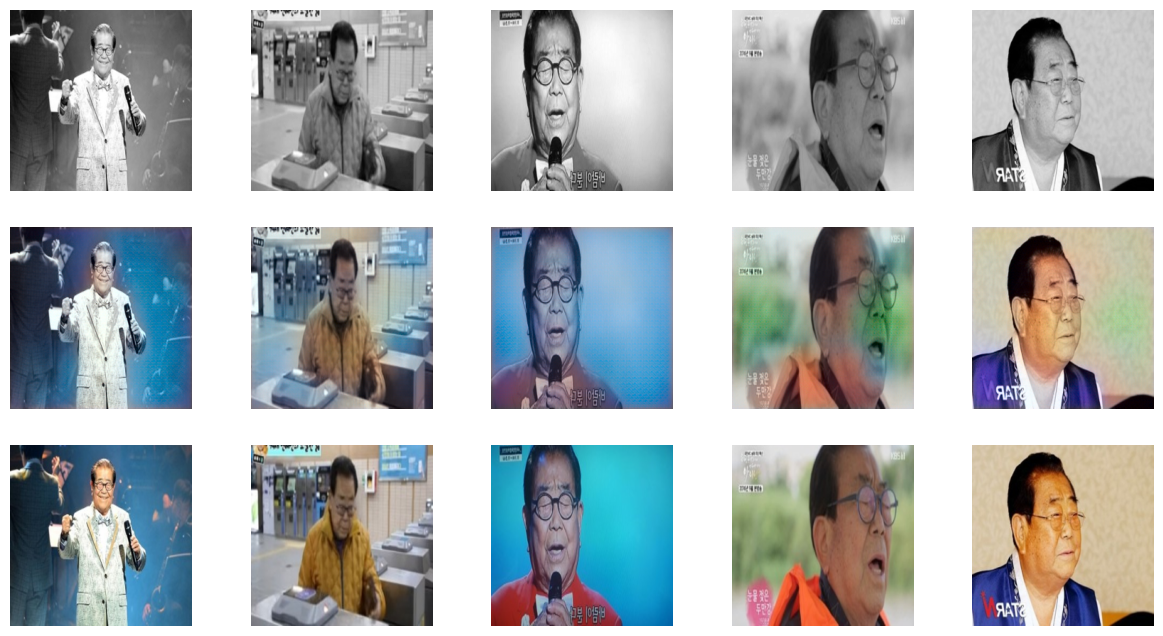


Epoch 1/1
Iteration 400/400
loss_D_fake: 0.61339
loss_D_real: 0.63645
loss_D: 0.62492
loss_G_GAN: 1.01335
loss_G_L1: 7.12823
loss_G: 8.14158


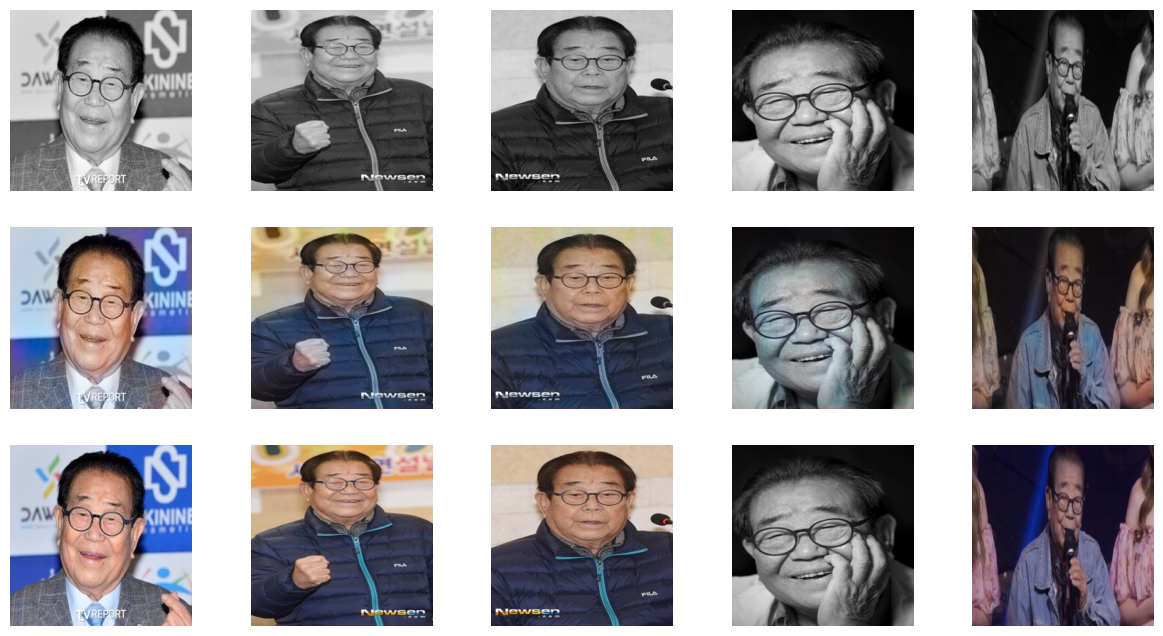

실행 시간: 3시간 54분 58초


In [ ]:
import time
# 시작 시간 기록
start_time = time.time()
# 여기에 실행하고자 하는 코드 작성

def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, 1)

# 종료 시간 기록
end_time = time.time()
# 실행 시간 계산 (종료 시간 - 시작 시간)
elapsed_time = end_time - start_time
# 실행 시간을 시, 분, 초로 변환
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
# 결과 출력
print(f"실행 시간: {int(hours)}시간 {int(minutes)}분 {int(seconds)}초")### 1.7- Training function



In [ ]:
# #주어진 에폭 동안 모델을 학습하고, 일정한 간격으로 손실을 출력하고 모델의 출력을 시각화하는 훈련 함수

# def train_model(model, train_dl, epochs, display_every=200):
#     """
#     모델을 학습하는 함수.

#     Args:
#         model: 학습할 모델.
#         train_dl: 학습 데이터로 구성된 데이터로더.
#         epochs (int): 학습할 에폭 수.
#         display_every (int): 일정 iteration 마다 결과를 표시할 빈도. 기본값은 200.
#     """
#     data = next(iter(val_dl)) # 고정된 간격으로 모델 출력을 시각화하기 위해 배치를 가져옵니다.
#     for e in range(epochs):
#         loss_meter_dict = create_loss_meters() # 네트워크의 손실을 기록할 물체들을 생성하는 함수
#         i = 0                                  # 전체 네트워크의 손실을 기록하기 위한 딕셔너리를 초기화합니다.
#         for data in tqdm(train_dl):
#             model.setup_input(data)
#             model.optimize()
#             update_losses(model, loss_meter_dict, count=data['L'].size(0)) # 손실을 업데이트하는 함수
#             i += 1
#             if i % display_every == 0:
#                 print(f"\nEpoch {e+1}/{epochs}")
#                 print(f"Iteration {i}/{len(train_dl)}")
#                 log_results(loss_meter_dict) # 손실을 출력하는 함수
#                 visualize(model, data, save=False) # 모델의 출력을 표시하는 함수

# model = MainModel()
# train_model(model, train_dl, epochs=100)


Every epoch takes about 3 to 4 minutes on Colab. After about 20 epochs you should see some reasonable results.

좋습니다. 모델을 더 오랜 시간 동안(약 100 에포크) 훈련시켰습니다. 여기에는 기준 모델의 결과가 있습니다:

![baseline](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/baseline.png?raw=1)

보시다시피, 이 기준 모델은 이미지의 일반적인 객체인 하늘, 나무 등에 대한 기본적인 이해를 가지고 있지만, 그 결과물은 매력적이지 않으며 드물게 등장하는 물체의 색상을 결정할 수 없습니다. 또한 색상이 넘치고 원형으로 된 색상 덩어리가 표시되는데(두 번째 행의 첫 번째 이미지의 중앙) 이는 전혀 좋지 않습니다. 따라서 이 작은 데이터셋으로는 이 전략으로 좋은 결과를 얻을 수 없는 것으로 보입니다. **따라서, 전략을 변경합니다!**

## 2- A new strategy - the final model

이 문서의 중점 부분입니다. 여기서 나는 앞서 언급한 문제를 극복하기 위해 수행한 작업에 대해 설명할 것입니다. 초해상도 문헌에서 영감을 받아 "더 많은 것을 모르는 사람이 더 많은 것을 가르친다"라는 문제를 피하기 위해 생성자를 감독 및 결정적으로 따로 사전 훈련하기로 결정했습니다. 여기서 생성자나 판별자가 교육 시작 시 작업에 대해 아무것도 모르는 "더 많은 것을 모르는 사람이 더 많은 것을 가르친다" 문제를 피하기 위해 생성자를 감독 및 결정적으로 사전 훈련하기로 결정했습니다.

실제로 나는 두 단계로 사전 훈련을 사용합니다: 1- 생성자의 백본(다운 샘플링 경로)은 ImageNet에서의 분류를 위해 사전 훈련된 모델입니다. 2- 전체 생성자는 L1 손실을 사용하여 색상화 작업에 대해 사전 훈련될 것입니다.

사실, 나는 U-Net의 백본으로 사전 훈련된 ResNet18을 사용할 것이며 두 번째 사전 훈련 단계를 완료하기 위해 U-Net을 L1 Loss만 사용하여 교육할 것입니다. 그런 다음 이전 섹션에서 한 것처럼 적대적 및 L1 손실을 결합합니다.

여기서부터는 텍스트의 일부가 누락된 것으로 보입니다. 누락된 부분이 있는 경우 특정 내용에 대해 물어보거나 원하는 내용에 대한 설명을 제공하실 수 있습니다. 이어지는 내용에 대해 자세히 알고 싶은 경우 질문해 주세요!

### 2.1- Using a new generator

ResNet 백본을 갖는 U-Net을 만드는 것은 쉬운 일이 아니므로 fastai 라이브러리의 Dynamic U-Net 모듈을 사용하여 쉽게 구축하겠습니다. fastai는 이미 설치되어 있지 않은 경우 pip 또는 conda로 설치할 수 있습니다(튜토리얼 시작 부분에서 이미 설치한 경우 다시 설치할 필요가 없습니다). [문서](https://docs.fast.ai/)에서 자세한 내용을 확인할 수 있습니다.

#### 2022년 1월 8일 업데이트: <br>
다음 코드 라인이 오류 없이 실행되려면 fastai 버전 2.4를 설치해야 합니다.
튜토리얼 시작 부분의 셀에서 이미 설치했다면 여기에서 다시 설치할 필요가 없습니다.

In [ ]:
# fastai 라이브러리의 버전 2.4를 설치합니다.
# fastai 라이브러리는 딥러닝 작업을 간편하게 수행할 수 있는 도구를 제공합니다.
!pip install fastai==2.4

# fastai.vision 패키지에서 create_body 함수와 resnet18 모델을 가져옵니다.
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18

# fastai.vision.models 패키지에서 DynamicUnet 클래스를 가져옵니다.
from fastai.vision.models.unet import DynamicUnet


In [ ]:
#ResNet18 기반의 U-Net 모델을 생성하는 역할

def build_res_unet(n_input=1, n_output=2, size=256):
    """
    ResNet18 기반의 U-Net 모델을 생성하는 함수.

    Args:
        n_input (int): 입력 채널 수. 기본값은 1.
        n_output (int): 출력 채널 수. 기본값은 2.
        size (int): 이미지 크기. 기본값은 256.

    Returns:
        nn.Module: ResNet18 기반의 U-Net 모델.
    """
    # 현재 사용 가능한 디바이스 확인
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ResNet18의 바디 부분을 가져와서 생성
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)

    # U-Net 모델 생성
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)

    return net_G


그게 전부입니다! 이 몇 줄의 코드만으로도 이러한 복잡한 모델을 쉽게 구축할 수 있습니다. `create_body` 함수는 ResNet18 아키텍처의 사전 훈련된 가중치를 로드하고 모델의 마지막 두 레이어(GlobalAveragePooling 및 ImageNet 분류 작업을 위한 선형 레이어)를 제거하기 위해 모델을 자릅니다. 그런 다음 `DynamicUnet`은 이 백본을 사용하여 필요한 출력 채널(우리의 경우 2)과 입력 크기 256을 갖는 U-Net을 구축합니다.

### 2.2 Pretraining the generator for colorization task

In [ ]:
#생성자를 사전 훈련하는 함수
#주어진 모델, 최적화기, 손실 함수 및 에폭 수로 생성자를 사전 훈련하고, 결과를 저장하는 부분

def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    """
    생성자(generator)를 사전 훈련하는 함수.

    Args:
        net_G: 사전 훈련할 생성자 모델.
        train_dl: 훈련 데이터로 구성된 데이터로더.
        opt: 최적화기(optimizer).
        criterion: 손실 함수.
        epochs (int): 훈련할 에폭 수.
    """
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            # 데이터를 GPU로 이동
            L, ab = data['L'].to(device), data['ab'].to(device)

            # 생성자에 입력을 전달하여 예측을 수행
            preds = net_G(L)

            # 손실 계산 및 역전파
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            # 손실 미터 업데이트
            loss_meter.update(loss.item(), L.size(0))

        # 에폭마다 손실 출력
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

# 모델 생성
net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()

# 생성자 사전 훈련
pretrain_generator(net_G, train_dl, opt, criterion, epochs=20)

# 모델 저장
# torch.save(net_G.state_dict(), "res18-unet.pt")


이 간단한 함수로 생성자를 20 에포크 동안 사전 훈련하고 그 가중치를 저장합니다. 이 작업은 Colab에서 1시간 정도 걸릴 것입니다. 다음 섹션에서는 이 모델을 GAN의 생성자로 사용하고 전체 네트워크를 이전과 같이 훈련시킵니다:

### 2.3 Putting everything together, again!


모델을 직접 훈련하려면 다음 셀을 실행하세요. 대신 사전 훈련된 가중치를 사용하려면 해당 셀을 건너뛰고 그 다음 셀을 실행하세요.

In [ ]:
#주어진 생성자 모델을 불러와 MainModel에 전달하고, 주어진 데이터로 모델을 학습하는 과정

# 생성자 모델을 구축합니다.
net_G = build_res_unet(n_input=1, n_output=2, size=256)

# 미리 훈련된 생성자 모델의 가중치를 로드합니다.
net_G.load_state_dict(torch.load("/content/drive/MyDrive/songhae/res18-unet.pth", map_location=device))

# MainModel 클래스의 인스턴스를 생성하고 미리 훈련된 생성자 모델을 전달합니다.
model = MainModel(net_G=net_G)

# 주어진 모델과 훈련 데이터로 train_model 함수를 사용하여 학습을 수행합니다.
# 주어진 에폭 수는 20입니다.
train_model(model, train_dl, epochs=20)


여기서 먼저 이전 섹션에서 저장한 생성자의 가중치를 로드한 다음 이 모델을 MainModel 클래스에서 생성자로 사용합니다. 이렇게 하면 생성자가 무작위로 초기화되지 않습니다. 그런 다음 10에서 20 에포크 동안 모델을 훈련합니다! (이전 섹션에서 사전 훈련을 사용하지 않았을 때 100 에포크와 비교하세요). 각 에포크는 Colab에서 약 3~4분이 소요됩니다.

In [ ]:
# gdown은 Google Drive에서 파일을 다운로드하기 위한 명령입니다.
# --id 플래그 다음에는 Google Drive에서 파일을 식별하는 고유 ID가 있습니다.
# 지정된 ID를 사용하여 Google Drive에서 파일을 가져와 로컬 디렉토리에 저장합니다.

# 아래 명령어는 지정된 Google Drive 파일 ID로부터 파일을 다운로드합니다.
!gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV


In [ ]:
# PyTorch의 torch.save 함수를 사용하여 모델의 상태 사전(state_dict)을 저장하는 코드입니다.
# model.state_dict()는 모델의 가중치와 매개변수를 포함하는 사전을 반환합니다.

# 저장된 파일 경로는 "/content/drive/MyDrive/songhae/final_model_weights.pt"로 지정되었습니다.
# 이 위치에 모델의 가중치가 저장됩니다.

# 모델의 학습된 가중치를 나중에 재사용하거나 다른 시스템에서 모델을 로드하여 사용할 때 유용합니다.
torch.save(model.state_dict(), "/content/drive/MyDrive/songhae/final_model_weights.pt")


In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("/content/drive/MyDrive/songhae/res18-unet.pth", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("/content/drive/MyDrive/songhae/final_model_weights.pt", map_location=device))

이제 이 최종 모델의 결과를 테스트 세트(훈련 중에 본 적이 없는 흑백 이미지)에 표시하겠습니다. 이에는 이 기사 초반의 주요 제목 이미지도 포함됩니다:

![output 1](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/main.png?raw=1)
Left: Input black & white images from test set | Right: the colorized outputs by the final model of this tutorial
---
![output2](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/img1.png?raw=1)
Left: Input black & white images from test set | Right: the colorized outputs by the final model of this tutorial
---
![output3](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/img2.png?raw=1)
Left: Input black & white images from test set | Right: the colorized outputs by the final model of this tutorial
---

## An accidental finding: You can safely remove Dropout!

이 기사 초반에 조건부 GAN의 이론을 설명할 때 해당 논문의 저자들이 제안한 생성자 아키텍처에서 노이즈의 원천은 dropout 레이어였다고 말했습니다. 그러나 fastai의 도움을 받아 구축한 U-Net을 조사할 때 거기에 dropout 레이어를 찾지 못했습니다! 사실, 나는 먼저 최종 모델을 훈련시키고 결과를 얻은 다음 생성자를 조사하여 이 사실을 알아냈습니다.

그렇다면 적대적 훈련은 무용했을까요? 노이즈가 없으면 생성자가 출력에 창의적인 효과를 가질 수 있을까요? 생성자에게 입력 그레이스케일 이미지가 노이즈 역할을 할 수 있을까요? 이것들이 그 당시 내 정확한 질문이었습니다.

그래서 나는 이 기사를 구현한 논문의 제일 저자인 Dr. Phillip Isola에게 이 질문들을 이메일로 보내고 친절하게도 그는 이 질문들에 답해 주었습니다. 그의 말에 따르면 이 조건부 GAN은 dropout이 없어도 여전히 작동할 수 있지만 그 노이즈 부족으로 인해 출력은 더 결정론적일 것이며 그럼에도 불구하고 입력 그레이스케일 이미지에는 여전히 충분한 정보가 있어 생성자가 흥미로운 출력을 생성할 수 있게 합니다.
사실, 실제로 적대적 훈련이 도움이 된 것을 보았습니다. 다음과 마지막 섹션에서는 사전 훈련된 U-Net의 결과와 적대적 훈련을 사용하여 얻은 최종 출력을 비교하겠습니다.

## Comparing the results of the pretrained U-Net with and without adversarial training

내 실험에서 발견한 멋진 점 중 하나는 ResNet18 백본을 사용하여 구축한 U-Net이 L1 Loss만 사용하여 사전 훈련 후 이미지를 훌륭하게 색칠한다는 것이었습니다(최종 적대적 훈련 이전의 단계). 그러나 모델은 여전히 보장이 없거나 물체가 무엇인지 또는 어떤 색이어야 하는지 확실하지 않을 때 회색과 비슷한 색상을 사용하도록 장려됩니다. 그러나 그것은 이미지의 일반적인 장면에 대해 정말 멋진 결과를 제공합니다.

여기에서는 적대적 훈련이 우리의 경우에 얼마나 큰 차이를 만들고 있는지를 더 잘 나타내기 위해 적대적 훈련 없이 사전 훈련된 U-Net 및 적대적 훈련을 받은 U-Net의 출력을 보여줍니다:

![comparison](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/comparison1.png?raw=1)
(왼쪽: 적대적 훈련 없이 사전 훈련된 U-Net | 오른쪽: 적대적 훈련을 받은 사전 훈련된 U-Net)
---

You can also see the GIF below to observe the difference between the images better:

![anim](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/anim_compare.gif?raw=1)
(animation of the last two images to better see the significant difference that adversarial training is making)
---

## Final words

이 프로젝트는 나에게 중요한 교훈으로 가득 찼습니다. 지난 달 동안 여러 논문을 구현하면서 각각 다른 전략을 사용했으며 상당한 시간이 걸렸습니다. 많은 실패 끝에 나는 이 훈련 방법을 생각해 내게 되었습니다. 이제 생성자를 사전 훈련하는 것이 모델을 크게 도왔고 결과를 향상시켰다는 것을 확인할 수 있습니다.

또한 처음에는 나쁜 실수처럼 느껴지는 몇 가지 관찰은 주의를 기울이고 더 심층적으로 조사할 가치가 있다는 것을 배웠습니다. 이 프로젝트에서 드롭아웃의 경우처럼요. 딥 러닝 및 AI의 도움 많은 커뮤니티 덕분에 전문가들에게 쉽게 질문하고 필요한 답을 얻을 수 있으며 단순한 추측에서 더 자신감을 얻을 수 있습니다.

이 훌륭한 논문의 저자들에게 그들의 멋진 작업에 감사드리고 또한 [이 논문의 훌륭한 GitHub 리포지토리](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)에서 일부 코드를 빌려왔습니다(수정 및 간소화 포함). 컴퓨터 과학 및 AI 커뮤니티와 그들이 분야를 개선하고 기여를 모두 이용 가능하게 하는 모든 노력을 진심으로 사랑하며 이 커뮤니티의 작은 부분이 된 것에 행복합니다.